In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
import h5py
import os,sys
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import glob
import copy
import re
import pickle

import sys
#sys.path.append('/home/thomas.callister/CBC/effective-spin-priors/')
#from priors import chi_effective_prior_from_isotropic_spins
#from priors import joint_prior_from_isotropic_spins

output_path = "preprocessed-single-events-rerun/"
import os
if output_path[:-1] not in os.listdir('./'):
    os.makedirs(output_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
import sys
sys.path.append('../code/')
sys.path.append('./')
import os
import h5py,json

plot_green = '#50A06E'
plot_blue = '#2A42A6'
plot_lightblue = '#2A52F4'
plot_orange = '#F4662A'
plot_red = '#A72A43'
plot_purple = '#8E2AA7'
plot_brown = '#6B6F59'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font',size=15)

#processed_samps_A = np.load('../results/processed_AllSamples_r00.npy','r')
#processed_samps_K = np.load('../results/processed_KDE_result_r01.npy','r')
#processed_samps_K0 = np.load('../../o3b-pop-studies-rerun/results/OG_prior/processed_gaussian_spin_samples_FAR_1_in_1_r00.npy','r')

In [3]:
#This is copy-paste code from '/home/thomas.callister/CBC/effective-spin-priors/priors.py'
import numpy as np
from scipy.stats import gaussian_kde
from scipy.special import spence as PL

def Di(z):

    """
    Wrapper for the scipy implmentation of Spence's function.
    Note that we adhere to the Mathematica convention as detailed in:
    https://reference.wolfram.com/language/ref/PolyLog.html

    Inputs
    z: A (possibly complex) scalar or array

    Returns
    Array equivalent to PolyLog[2,z], as defined by Mathematica
    """

    return PL(1.-z+0j)

def chi_effective_prior_from_aligned_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_eff|q) corresponding to
    uniform, aligned component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_effective value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = (xs>aMax*(1.-q)/(1.+q))*(xs<=aMax)
    caseB = (xs<-aMax*(1.-q)/(1.+q))*(xs>=-aMax)
    caseC = (xs>=-aMax*(1.-q)/(1.+q))*(xs<=aMax*(1.-q)/(1.+q))

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]

    pdfs[caseA] = (1.+q)**2.*(aMax-x_A)/(4.*q*aMax**2)
    pdfs[caseB] = (1.+q)**2.*(aMax+x_B)/(4.*q*aMax**2)
    pdfs[caseC] = (1.+q)/(2.*aMax)

    return pdfs

def chi_effective_prior_from_isotropic_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_eff|q) corresponding to
    uniform, isotropic component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_effective value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(np.abs(xs),-1)

    # Set up various piecewise cases
    pdfs = np.ones(xs.size,dtype=complex)*(-1.)
    caseZ = (xs==0)
    caseA = (xs>0)*(xs<aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseB = (xs<aMax*(1.-q)/(1.+q))*(xs>q*aMax/(1.+q))
    caseC = (xs>aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseD = (xs>aMax*(1.-q)/(1.+q))*(xs<aMax/(1.+q))*(xs>=q*aMax/(1.+q))
    caseE = (xs>aMax*(1.-q)/(1.+q))*(xs>aMax/(1.+q))*(xs<aMax)
    caseF = (xs>=aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]
    x_D = xs[caseD]
    x_E = xs[caseE]

    pdfs[caseZ] = (1.+q)/(2.*aMax)*(2.-np.log(q))

    pdfs[caseA] = (1.+q)/(4.*q*aMax**2)*(
                    q*aMax*(4.+2.*np.log(aMax) - np.log(q**2*aMax**2 - (1.+q)**2*x_A**2))
                    - 2.*(1.+q)*x_A*np.arctanh((1.+q)*x_A/(q*aMax))
                    + (1.+q)*x_A*(Di(-q*aMax/((1.+q)*x_A)) - Di(q*aMax/((1.+q)*x_A)))
                    )

    pdfs[caseB] = (1.+q)/(4.*q*aMax**2)*(
                    4.*q*aMax
                    + 2.*q*aMax*np.log(aMax)
                    - 2.*(1.+q)*x_B*np.arctanh(q*aMax/((1.+q)*x_B))
                    - q*aMax*np.log((1.+q)**2*x_B**2 - q**2*aMax**2)
                    + (1.+q)*x_B*(Di(-q*aMax/((1.+q)*x_B)) - Di(q*aMax/((1.+q)*x_B)))
                    )

    pdfs[caseC] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_C)
                    - (1.+q)*x_C*np.log(aMax)**2.
                    + (aMax + (1.+q)*x_C*np.log((1.+q)*x_C))*np.log(q*aMax/(aMax-(1.+q)*x_C))
                    - (1.+q)*x_C*np.log(aMax)*(2. + np.log(q) - np.log(aMax-(1.+q)*x_C))
                    + q*aMax*np.log(aMax/(q*aMax-(1.+q)*x_C))
                    + (1.+q)*x_C*np.log((aMax-(1.+q)*x_C)*(q*aMax-(1.+q)*x_C)/q)
                    + (1.+q)*x_C*(Di(1.-aMax/((1.+q)*x_C)) - Di(q*aMax/((1.+q)*x_C)))
                    )

    pdfs[caseD] = (1.+q)/(4.*q*aMax**2)*(
                    -x_D*np.log(aMax)**2
                    + 2.*(1.+q)*(aMax-x_D)
                    + q*aMax*np.log(aMax/((1.+q)*x_D-q*aMax))
                    + aMax*np.log(q*aMax/(aMax-(1.+q)*x_D))
                    - x_D*np.log(aMax)*(2.*(1.+q) - np.log((1.+q)*x_D) - q*np.log((1.+q)*x_D/aMax))
                    + (1.+q)*x_D*np.log((-q*aMax+(1.+q)*x_D)*(aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*np.log(aMax/((1.+q)*x_D))*np.log((aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*(Di(1.-aMax/((1.+q)*x_D)) - Di(q*aMax/((1.+q)*x_D)))
                    )

    pdfs[caseE] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_E)
                    - (1.+q)*x_E*np.log(aMax)**2
                    + np.log(aMax)*(
                        aMax
                        -2.*(1.+q)*x_E
                        -(1.+q)*x_E*np.log(q/((1.+q)*x_E-aMax))
                        )
                    - aMax*np.log(((1.+q)*x_E-aMax)/q)
                    + (1.+q)*x_E*np.log(((1.+q)*x_E-aMax)*((1.+q)*x_E-q*aMax)/q)
                    + (1.+q)*x_E*np.log((1.+q)*x_E)*np.log(q*aMax/((1.+q)*x_E-aMax))
                    - q*aMax*np.log(((1.+q)*x_E-q*aMax)/aMax)
                    + (1.+q)*x_E*(Di(1.-aMax/((1.+q)*x_E)) - Di(q*aMax/((1.+q)*x_E)))
                    )

    pdfs[caseF] = 0.

    # Deal with spins on the boundary between cases
    if np.any(pdfs==-1):
        boundary = (pdfs==-1)
        pdfs[boundary] = 0.5*(chi_effective_prior_from_isotropic_spins(q,aMax,xs[boundary]+1e-6)\
                        + chi_effective_prior_from_isotropic_spins(q,aMax,xs[boundary]-1e-6))

    return np.real(pdfs)

def chi_p_prior_from_isotropic_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_p|q) corresponding to
    uniform, isotropic component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_p value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = xs<q*aMax*(3.+4.*q)/(4.+3.*q)
    caseB = (xs>=q*aMax*(3.+4.*q)/(4.+3.*q))*(xs<aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]

    pdfs[caseA] = (1./(aMax**2*q))*((4.+3.*q)/(3.+4.*q))*(
                    np.arccos((4.+3.*q)*x_A/((3.+4.*q)*q*aMax))*(
                        aMax
                        - np.sqrt(aMax**2-x_A**2)
                        + x_A*np.arccos(x_A/aMax)
                        )
                    + np.arccos(x_A/aMax)*(
                        aMax*q*(3.+4.*q)/(4.+3.*q)
                        - np.sqrt(aMax**2*q**2*((3.+4.*q)/(4.+3.*q))**2 - x_A**2)
                        + x_A*np.arccos((4.+3.*q)*x_A/((3.+4.*q)*aMax*q))
                        )
                    )
                    
    pdfs[caseB] = (1./aMax)*np.arccos(x_B/aMax)

    return pdfs

def joint_prior_from_isotropic_spins(q,aMax,xeffs,xps,ndraws=10000,bw_method='scott'):

    """
    Function to calculate the conditional priors p(xp|xeff,q) on a set of {xp,xeff,q} posterior samples.

    INPUTS
    q: Mass ratio
    aMax: Maximimum spin magnitude considered
    xeffs: Effective inspiral spin samples
    xps: Effective precessing spin values
    ndraws: Number of draws from the component spin priors used in numerically building interpolant

    RETURNS
    p_chi_p: Array of priors on xp, conditioned on given effective inspiral spins and mass ratios
    """

    # Convert to arrays for safety
    xeffs = np.reshape(xeffs,-1)
    xps = np.reshape(xps,-1)
    
    # Compute marginal prior on xeff, conditional prior on xp, and multiply to get joint prior!
    p_chi_eff = chi_effective_prior_from_isotropic_spins(q,aMax,xeffs)
    p_chi_p_given_chi_eff = np.array([chi_p_prior_given_chi_eff_q(q,aMax,xeffs[i],xps[i],ndraws,bw_method) for i in range(len(xeffs))])
    joint_p_chi_p_chi_eff = p_chi_eff*p_chi_p_given_chi_eff

    return joint_p_chi_p_chi_eff

def chi_p_prior_given_chi_eff_q(q,aMax,xeff,xp,ndraws=10000,bw_method='scott'):

    """
    Function to calculate the conditional prior p(xp|xeff,q) on a single {xp,xeff,q} posterior sample.
    Called by `joint_prior_from_isotropic_spins`.

    INPUTS
    q: Single posterior mass ratio sample
    aMax: Maximimum spin magnitude considered
    xeff: Single effective inspiral spin sample
    xp: Single effective precessing spin value
    ndraws: Number of draws from the component spin priors used in numerically building interpolant

    RETURNS
    p_chi_p: Prior on xp, conditioned on given effective inspiral spin and mass ratio
    """

    # Draw random spin magnitudes.
    # Note that, given a fixed chi_eff, a1 can be no larger than (1+q)*chi_eff,
    # and a2 can be no larger than (1+q)*chi_eff/q
    a1 = np.random.random(ndraws)*aMax
    a2 = np.random.random(ndraws)*aMax

    # Draw random tilts for spin 2
    cost2 = 2.*np.random.random(ndraws)-1.

    # Finally, given our conditional value for chi_eff, we can solve for cost1
    # Note, though, that we still must require that the implied value of cost1 be *physical*
    cost1 = (xeff*(1.+q) - q*a2*cost2)/a1  

    # While any cost1 values remain unphysical, redraw a1, a2, and cost2, and recompute
    # Repeat as necessary
    while np.any(cost1<-1) or np.any(cost1>1):   
        to_replace = np.where((cost1<-1) | (cost1>1))[0]   
        a1[to_replace] = np.random.random(to_replace.size)*aMax
        a2[to_replace] = np.random.random(to_replace.size)*aMax
        cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
        cost1 = (xeff*(1.+q) - q*a2*cost2)/a1   
            
    # Compute precessing spins and corresponding weights, build KDE
    # See `Joint-ChiEff-ChiP-Prior.ipynb` for a discussion of these weights
    Xp_draws = chi_p_from_components(a1,a2,cost1,cost2,q)
    jacobian_weights = (1.+q)/a1
    prior_kde = gaussian_kde(Xp_draws,weights=jacobian_weights,bw_method=bw_method)

    # Compute maximum chi_p
    if (1.+q)*np.abs(xeff)/q<aMax:
        max_Xp = aMax
    else:
        max_Xp = np.sqrt(aMax**2 - ((1.+q)*np.abs(xeff)-q)**2.)

    # Set up a grid slightly inside (0,max chi_p) and evaluate KDE
    reference_grid = np.linspace(0.02*max_Xp,0.98*max_Xp,50)
    reference_vals = prior_kde(reference_grid)

    # Manually prepend/append zeros at the boundaries
    reference_grid = np.concatenate([[0],reference_grid,[max_Xp]])
    reference_vals = np.concatenate([[0],reference_vals,[0]])
    norm_constant = np.trapz(reference_vals,reference_grid)

    # Interpolate!
    p_chi_p = np.interp(xp,reference_grid,reference_vals/norm_constant)
    return p_chi_p

def chi_p_from_components(a1,a2,cost1,cost2,q):

    """
    Helper function to define effective precessing spin parameter from component spins

    INPUTS
    a1: Primary dimensionless spin magnitude
    a2: Secondary's spin magnitude
    cost1: Cosine of the primary's spin-orbit tilt angle
    cost2: Cosine of the secondary's spin-orbit tilt
    q: Mass ratio

    RETRUNS
    chi_p: Corresponding precessing spin value
    """

    sint1 = np.sqrt(1.-cost1**2)
    sint2 = np.sqrt(1.-cost2**2)
    
    return np.maximum(a1*sint1,((3.+4.*q)/(4.+3.*q))*q*a2*sint2)

In [4]:
import numpy as np
import scipy

def Joint_prob_Xeff_Xp(Xeff,Xp,q = 1,amax = 1,flag_debug = False):
    r'''
    Returns Joint prior on Effective Spin parameter Xeff and Precessing Spin Parameter Xp,
    given Mass ratio q, Max allowed spin magnitude amax, $p(Xeff,Xp|q,amax)$.
    Assumes $q>0$ and $0<amax<=1.$ $q>1$ inputs are interepreted as $1/q$.
    if flag_debug is True, then the function shows some integration for debugging and returns 4 integrals separately.
    '''
    assert (amax <= 1)*(amax > 0),"Invalid amax. 0<amax<=1 is accepted."
    
    def S(z):
        r'''
        Spence's function or dilogarithm Li_2(z).
        '''
        return scipy.special.spence(1-z)

    def g(x0,a0,b0):
        r'''
        Primitive function of log(x-bi)/(x-a-i) (x>=0).
        '''                    
        ans = np.zeros(len(a0))+0j
        case_special = (b0 == 0)*(x0 == 0)
        case_b_less_1 = (np.abs(b0) < 1)*(np.logical_not(case_special))
        case_b_1_a_less_0 = (b0 == 1)*(a0 <= 0)
        case_otherwise = np.logical_not(case_b_less_1|case_b_1_a_less_0|case_special)
        
        for j, case in enumerate([case_special,case_b_less_1,case_b_1_a_less_0,case_otherwise]):
            if np.any(case):
                x = x0[case]
                a = a0[case]
                b = b0[case]
                if j == 0:
                    ans[case] = 0
                if j == 1:
                    ans[case] = np.log(x-b*1j)*np.log((a-x+1j)/(a+1j-b*1j))+S((x-b*1j)/(a+1j-b*1j))
                if j == 2:
                    ans[case] = 1/2*(np.log(x-a-1j))**2+S(-a/(x-a-1j))
                if j == 3:
                    ans[case] = np.log(a+1j-b*1j)*np.log(a-x+1j)-S((a-x+1j)/(a+1j-b*1j))
        return ans
        
        

    def G(x0,a0,b0):
        r'''
        \int_0^x((x^2+b^2))/(1+(x-a)^2) dx.
        '''
        
        case_positive_x = (x0 > 0)
        case_negative_x = (x0 < 0)
        ans = np.zeros(len(x0))
        
        for j,case in enumerate([case_positive_x,case_negative_x]):
            if np.any(case):
                x = x0[case]
                a = a0[case]
                b = b0[case]
                if j == 0:
                    if flag_debug:
                        print("Given Values to H(x,a,b):")
                        print('x',x)
                        print('a',a)
                        print('b',b)
                        print('')
                    ans[case] = np.imag(g(x,a,b)+g(x,a,-b))-np.imag(g(np.zeros(len(x)),a,b)+g(np.zeros(len(x)),a,-b))
                if j == 1:
                    if flag_debug:
                        print('Avoid x<0 by transposing.')
                    ans[case] = -G(-x,-a,b)
        return ans

    def F(_x,_a,_b,_c,_d):
        r'''
        \int_0^x b*log((x^2+c^2)/d^2)/(b^2+(x-a)^2) dx.
        '''
        if np.any(_d == 0):
            print('Something is wrong!')
            raise ValueError
            
        x0 = np.atleast_1d(_x)
        a0 = np.atleast_1d(_a)
        b0 = np.atleast_1d(_b)
        c0 = np.atleast_1d(_c)
        d0 = np.atleast_1d(_d)
        max_len = len(b0)
        arr = np.zeros((5,max_len))
        for j, X in enumerate([x0,a0,b0,c0,d0]):
            if X.shape[0] == 1:
                arr[j,:] = X[0]
            else:
                arr[j,:] = X[:]
        x0,a0,b0,c0,d0 = arr
        
        if flag_debug:
            print(x0,a0,b0,c0,d0)
        ans = np.zeros(len(b0))
        case = (b0 != 0)
        x = x0[case]
        a = a0[case]
        b = b0[case]
        c = c0[case]
        d = d0[case]
        ans[case] = G(x/b,a/b,c/b) + np.log(b*b/d/d)*(np.arctan(a/b)+np.arctan((x-a)/b))
        return ans


    def Joint_prob_Xeff_Xp_1(_Xeff,_Xp,_q,flag_debug):
        r'''
        Returns Joint prior on Effective Spin parameter Xeff and Precessing Spin Parameter Xp, given Mass ratio q.
        Max allowed spin magnitude amax is assumed to be amax=1.
        '''
        Xp = np.atleast_1d(_Xp)
        Xeff = np.atleast_1d(_Xeff)
        q = np.atleast_1d(_q)
        assert np.min(q) > 0
        q[q>1] = 1/q[q>1]
    
        zeta = (1+q)*Xeff
        nu = (4+3*q)/(3+4*q)
    
        max_len = np.max([Xp.shape[0],Xeff.shape[0],q.shape[0]])
        arr = np.zeros((5,max_len))
        for j, X in enumerate([Xeff,Xp,q,zeta,nu]):
            if X.shape[0] == 1:
                arr[j,:] = X[0]
            else:
                arr[j,:] = X[:]
            
        Xeff0,Xp0,q0,zeta0,nu0 = arr
        threshold = q0/nu0
    
        case_OoB = np.logical_or((Xp0 <= 0),(Xp0 >= 1))
        case_lsr_than_threshold = np.logical_and(np.logical_not(case_OoB),(Xp0 < threshold))
        case_gtr_than_threshold = np.logical_and(np.logical_not(case_OoB),(Xp0 >= threshold))
    
        #Joint PDF is a sum of 4 integrals
        int_1 = np.zeros(max_len)
        int_2 = np.zeros(max_len)
        int_3 = np.zeros(max_len)
        int_4 = np.zeros(max_len)
    
        for j,case in enumerate([case_OoB,
                                case_lsr_than_threshold,
                                case_gtr_than_threshold]):
            if np.any(case):
                Xeff = Xeff0[case]
                Xp = Xp0[case]
                q = q0[case]
                zeta = zeta0[case]
                nu = nu0[case]
            
                if j != 0:
                #Only int_2 have non-zero value for j = 2
                    max_2 = np.minimum(zeta+np.sqrt(1-Xp*Xp),q)
                    min_2 = np.maximum(zeta-np.sqrt(1-Xp*Xp),-q)
                    zero = (min_2 > max_2)
                    if np.any(zero):
                        max_2[zero] = min_2[zero]
                    if flag_debug:
                        print('Calculating 2nd integral for j = {}'.format(j))
                        print('x_max:',max_2)
                        print('x_min:',min_2)
                    int_2[case] = -(1+q)/8/q * (F(max_2,zeta,Xp,0,q)-F(min_2,zeta,Xp,0,q))
                
                #int_1,int_3,int_4 have none-zero value only if j = 1
                    if j == 1:
                    
                        #int_1
                        max_1 = np.minimum(zeta+np.sqrt(1-Xp*Xp),np.sqrt(q*q-nu*nu*Xp*Xp))
                        min_1 = np.maximum(zeta-np.sqrt(1-Xp*Xp),-np.sqrt(q*q-nu*nu*Xp*Xp))
                        zero = (min_1 > max_1)                            
                        if np.any(zero):
                            max_1[zero] = min_1[zero]
                        if flag_debug:
                            print('Calculating 1st integral')
                            print('x_max:',max_1)
                            print('x_min:',min_1)
                        int_1[case] = (1+q)/8/q * (F(max_1,zeta,Xp,nu*Xp,q)-F(min_1,zeta,Xp,nu*Xp,q))
                    
                        #int_3
                        max_3 = np.minimum(zeta+np.sqrt(q*q-nu*nu*Xp*Xp),np.sqrt(1-Xp*Xp))
                        min_3 = np.maximum(zeta-np.sqrt(q*q-nu*nu*Xp*Xp),-np.sqrt(1-Xp*Xp))
                        zero = (min_3 > max_3)
                        if np.any(zero):
                            max_3[zero] = min_3[zero]
                        if flag_debug:
                            print('Calculating 3rd integral')
                            print('x_max:',max_3)
                            print('x_min:',min_3)
                        int_3[case] = (1+q)*nu/8/q * (F(max_3,zeta,nu*Xp,Xp,1)-F(min_3,zeta,nu*Xp,Xp,1))
                    
                        #int_4
                        max_4 = np.minimum(zeta+np.sqrt(q*q-nu*nu*Xp*Xp),q/q)
                        min_4 = np.maximum(zeta-np.sqrt(q*q-nu*nu*Xp*Xp),-q/q)
                        zero = (min_4 > max_4)
                        if np.any(zero):
                            max_4[zero] = min_4[zero]
                        if flag_debug:
                            print('Calculating 4th integral')
                            print('x_max:',max_4)
                            print('x_min:',min_4)
                        int_4[case] = -(1+q)*nu/8/q * (F(max_4,zeta,nu*Xp,0,1)-F(min_4,zeta,nu*Xp,0,1))
                    
        if flag_debug:
            return int_1,int_2,int_3,int_4
        elif max_len == 1:
            return (int_1+int_2+int_3+int_4)[0]
        return int_1+int_2+int_3+int_4
    
    if flag_debug:
        int_1,int_2,int_3,int_4 = Joint_prob_Xeff_Xp_1(Xeff/amax,Xp/amax,q,flag_debug)
        return int_1/amax/amax,int_2/amax/amax,int_3/amax/amax,int_4/amax/amax
    return Joint_prob_Xeff_Xp_1(Xeff/amax,Xp/amax,q,flag_debug)/amax/amax


# Prelim

First, define some helper functions to compute chi_effective and chi_p

In [5]:
def Calculate_Xp(m1, m2, a1, a2, costilt1, costilt2):
    
    q = m2/m1
    sintilt1 = np.sqrt(1-(costilt1)**2)
    sintilt2 = np.sqrt(1-(costilt2)**2)
    
    return np.maximum(a1*sintilt1, (3.+4.*q)/(4.+3.*q)*q*a2*sintilt2)

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

def eta(m1,m2):
    return m1*m2/(m1+m2)/(m1+m2)

def Mc(m1,m2):
    return np.power(eta(m1,m2),3./5.)*(m1+m2)

In [6]:
#eventDict = h5py.File('/home/thomas.callister/CBC/o3b-astro-dist/events.hdf','r')
eventDict = h5py.File('../other_files/events.hdf','r')

#eventKeyFile = "/home/thomas.callister/CBC/o3b-astro-dist/bin/fetch_o3b_pe_for_rp/event_to_run.json"
eventKeyFile = "../other_files/event_to_run.json"
with open(eventKeyFile,'r') as jf:
    eventKeyDict = json.load(jf)

# O1/O2

In [7]:
O1O2_events = np.array([])

for key in eventDict['O1']:
    O1O2_events = np.append(O1O2_events,str(key))
    
for key in eventDict['O2']:
    if key!='GW170817':
        O1O2_events = np.append(O1O2_events,str(key))
    
print(O1O2_events)

['GW150914' 'GW151012' 'GW151226' 'GW170104' 'GW170608' 'GW170729'
 'GW170809' 'GW170814' 'GW170818' 'GW170823']


In [8]:
overall_Xeff = []
overall_Xp = []
overall_q = []
for key in O1O2_events:
    BBH_post = h5py.File('../other_files/GWTC-1_Sample_Release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    
    # Mass ratio
    q = m2_DF/m1_DF
    
    overall_Xeff.append(Xeff)
    overall_Xp.append(Xp)
    overall_q.append(q)
    

overall_Xeff_O1O2 = np.concatenate(overall_Xeff).tolist()
overall_Xp_O1O2 = np.concatenate(overall_Xp).tolist()
overall_q_O1O2 = np.concatenate(overall_q).tolist()
len(overall_Xeff_O1O2),len(overall_Xp_O1O2),len(overall_q_O1O2)

(178172, 178172, 178172)

# O3

<span style="color: red; ">eventDict['O3'][key]['FAR']['minfar'].valueは現在のpythonでは読み込めないので、書式変更</span>

In [9]:
O3_events = np.array([])
year = 365.25*24.*3600

# GW190425 is a BNS
# GW190426, GW200105, and GW200115 are NSBH candidates
# GW190917 is a mass gap event
to_exclude = ['S190425z','S190426c','S190917u','S200105ae','S200115j']
for key in eventDict['O3']:
    if key not in to_exclude:
        
        if key=="%s":
            continue
        
        #print(key)
        #FAR_in_years = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
        FAR_in_years = float(eventDict['O3'][key]['FAR']['minfar'][()])*year
        if FAR_in_years<=1.:
            O3_events = np.append(O3_events,str(key))
    
print(len(O3_events))
#print(O3_events)

60


In [10]:
overall_Xeff = []
overall_Xp = []
overall_q = []
for event in tqdm(O3_events):
    
    #hfile = "/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/{0}.h5".format(event)
    hfile = "../other_files/GWTC-3_Sample_Release/{0}.h5".format(event)
    if not os.path.isfile(hfile):
        print("Cannot find file",event)
        continue
        
    if event in ["GW170817","S190425z",'S190426c','S190531n','S190917u','S200105ae','S200115j','S190814bv']:
        print('Skipped')
        continue
        
        
    f = h5py.File(hfile,'r')    
    pe_key = eventKeyDict[event]
    BBH_post_samples = f[pe_key]['posterior_samples']
    
    m1_SF = BBH_post_samples['mass_1_source']
    m2_SF = BBH_post_samples['mass_2_source']
    a1 = BBH_post_samples['a_1']
    a2 = BBH_post_samples['a_2']
    cost1 = BBH_post_samples['cos_tilt_1']
    cost2 = BBH_post_samples['cos_tilt_2']
    DL = BBH_post_samples['luminosity_distance']
    z = BBH_post_samples['redshift']
    
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
    q = m2_SF/m1_SF
    
    overall_Xeff.append(Xeff)
    overall_Xp.append(Xp)
    overall_q.append(q)
    

overall_Xeff_O3 = np.concatenate(overall_Xeff).tolist()
overall_Xp_O3 = np.concatenate(overall_Xp).tolist()
overall_q_O3 = np.concatenate(overall_q).tolist()

  0%|          | 0/60 [00:00<?, ?it/s]

Skipped


In [11]:
len(overall_Xeff_O3)

2601520

# Injections

In [12]:
injection_K = np.load('../code/injectionDict_rerun_directMixture_FAR_1_in_1_K.pickle',allow_pickle=True)
Xeff_inj = injection_K['Xeff']
Xp_inj = injection_K['Xp']
m1_inj = injection_K['m1']
m2_inj = injection_K['m2']
q_inj = m2_inj/m1_inj


# Combine

In [13]:
Xeff_samps = np.concatenate([overall_Xeff_O1O2,overall_Xeff_O3,Xeff_inj])
Xp_samps = np.concatenate([overall_Xp_O1O2,overall_Xp_O3,Xp_inj])
q_samps = np.concatenate([overall_q_O1O2,overall_q_O3,q_inj])

len(Xeff_samps)

2819452

In [14]:
import time
t0_A = time.time()
Analytical_results = Joint_prob_Xeff_Xp(Xeff_samps,Xp_samps,q_samps)
t1_A = time.time()

t1_A-t0_A

39.62742805480957

In [15]:
def Eff(q,Xeff):
    X = np.abs(Xeff)
    if q == 0:
        return 1
    
    def integ(x):
        if x == 0:
            return 0
        return x*x/4*(3-2*np.log(np.abs(x)/q))
    def part_1(q,X):
        return (integ(q)-integ((1+q)*X))*((q - (1+q)*X) > 0)
    def part_2(q,X):
        A = np.abs(q-(1+q)*X)
        return q*np.maximum((1-A),0)
    def part_3(q,X):
        M = np.minimum(q,1-(1+q)*X)
        m = np.maximum(-q,-(1+q)*X)
        return (integ(M)-integ(m))*((M-m) > 0)
    def part_4(q,X):
        return q*np.maximum((1-q-(1+q)*X),0)
    return np.maximum(0,(part_1(q,X)+part_2(q,X)+part_3(q,X)+part_4(q,X))/2/q)

In [16]:
import numpy as np

def Eff_vec(q, Xeff):
    # 入力をnumpy arrayに変換
    q = np.asarray(q)
    Xeff = np.asarray(Xeff)
    X = np.abs(Xeff)
    
    # q=0のケースを処理
    result = np.ones_like(q)
    mask_nonzero = (q != 0)
    
    def integ(x):
        # x=0のケースを処理
        result = np.zeros_like(x)
        mask_nonzero = (x != 0)
        # 非ゼロの要素に対してのみ計算
        result[mask_nonzero] = x[mask_nonzero]**2/4*(3-2*np.log(np.abs(x[mask_nonzero])/q[mask_nonzero]))
        return result
    
    def part_1(q, X):
        condition = (q - (1+q)*X) > 0
        return (integ(q) - integ((1+q)*X)) * condition
    
    def part_2(q, X):
        A = np.abs(q-(1+q)*X)
        return q * np.maximum((1-A), 0)
    
    def part_3(q, X):
        M = np.minimum(q, 1-(1+q)*X)
        m = np.maximum(-q, -(1+q)*X)
        return (integ(M) - integ(m)) * ((M-m) > 0)
    
    def part_4(q, X):
        return q * np.maximum((1-q-(1+q)*X), 0)
    
    # q≠0の要素に対してのみ計算
    nonzero_result = np.maximum(0, (part_1(q[mask_nonzero], X[mask_nonzero]) + 
                                   part_2(q[mask_nonzero], X[mask_nonzero]) + 
                                   part_3(q[mask_nonzero], X[mask_nonzero]) + 
                                   part_4(q[mask_nonzero], X[mask_nonzero])) / 2 / q[mask_nonzero])
    
    result[mask_nonzero] = nonzero_result
    return result

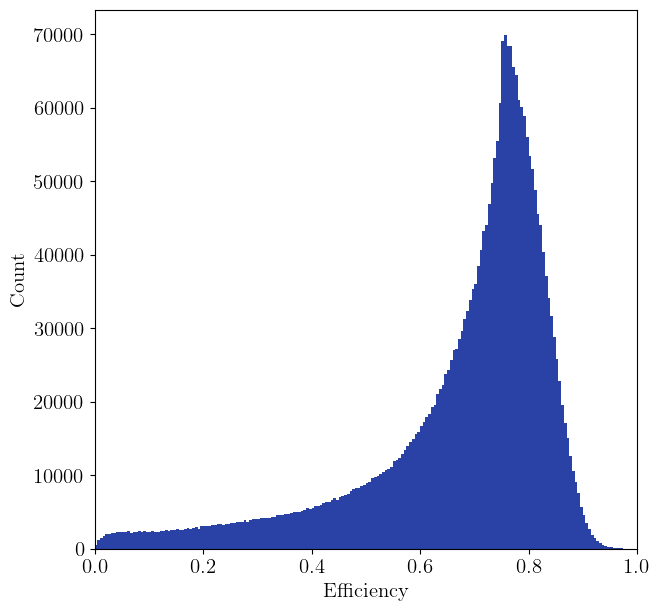

In [41]:

plt.figure(figsize=(7,7))
plt.hist(Eff_vec(q_samps,Xeff_samps),range=(0,1),bins=200,color=plot_blue)
plt.xlabel('Efficiency')
plt.ylabel('Count')
plt.xlim(0,1)
plt.savefig('Practical_Efficiency.pdf')

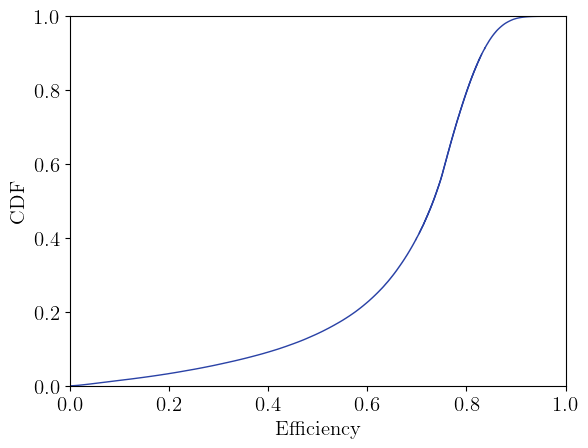

In [36]:
plt.hist(Eff_vec(q_samps,Xeff_samps),range=(0,1.1),bins=10000,cumulative=True,histtype='step',density=True,color=plot_blue)
plt.xlabel('Efficiency')
plt.ylabel('CDF')
plt.xlim(0,1)
#plt.yscale('log')
plt.ylim(0,1)
#plt.savefig('Practical_Efficiency.pdf')

(0.0, 1.0)

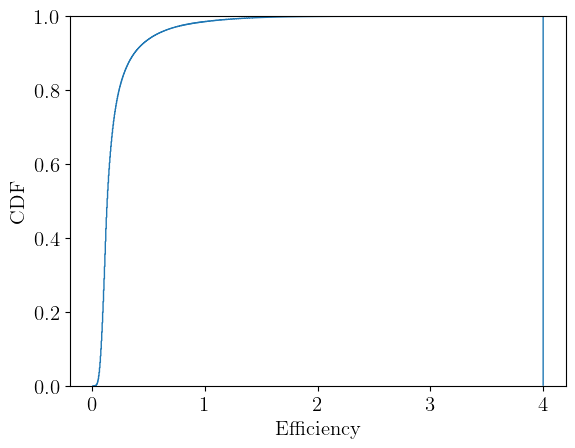

In [31]:
plt.hist(np.log10(1/Eff_vec(q_samps,Xeff_samps)),range=(0,4),bins=1000,cumulative=True,histtype='step',density=True)
plt.xlabel('Efficiency')
plt.ylabel('CDF')
#plt.xlim(0,1)
#plt.yscale('log')
plt.ylim(0,1)

In [28]:
1/np.min(Eff_vec(q_samps,Xeff_samps))

4226.367017971235